Students: 
- Davide Cremonini - 14412
- Davide Sbetti - 14032

# Fake Job Postings Detector

For our project (type 1 and 3 project), we decided to use the "Fake Real Job Postings Prediction" dataset, retrieved on Kaggle at the following address: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

The dataset contains 18.000 job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. Our goal is to predict, based on the job description attribute, whether the posting is a real or fake one. 

We decided to implement a Neural Network and to compare the resulting implementation with sklearn Multi-Layer Perceptron and with Keras.

***
## Import libraries

We import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import confusion_matrix


Bad key "text.kerning_factor" on line 4 in
/Users/DavideCremonini/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


***
## Reading the dataset

We read the input dataset and we visualize the first 5 rows

In [2]:
fake_real_postings = pd.read_csv("data/fake_job_postings.csv")
fake_real_postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


We check how many null values we have in the different features, distinguishing between two classes

In [3]:
real_postings = fake_real_postings[fake_real_postings["fraudulent"] == 0]
real_null = real_postings.isnull().sum(axis = 0) / real_postings.shape[0]

fake_postings = fake_real_postings[fake_real_postings["fraudulent"] == 1]
fake_null = fake_postings.isnull().sum(axis = 0) / fake_postings.shape[0]

We plot the results

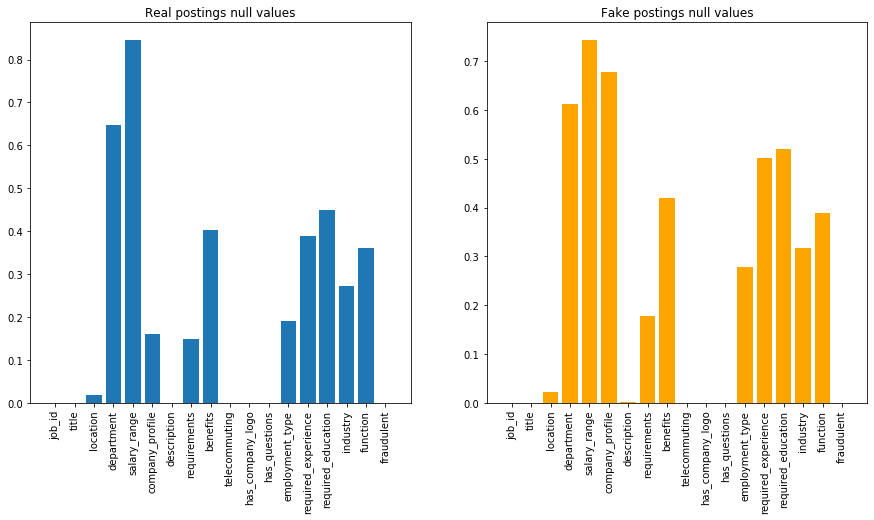

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

ax1.bar(real_null.index,real_null.values)

ax1.set_xticklabels(real_null.index,rotation = 90)

ax1.title.set_text("Real postings null values")

ax2.bar(fake_null.index,fake_null.values, color = "orange")

ax2.set_xticklabels(fake_null.index,rotation = 90)

ax2.title.set_text("Fake postings null values")

plt.show()

We check how many unique values we have for each different feature. This is useful to understand how to effectively pre-process our dataset and which strategies should be applied to the different features.

In [5]:
fake_real_postings.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

***
## Data pre-processing

In this section we pre-process our dataset, splitting and then removing some columns, applying one-hot encoding, tf-idf vectorisation and dealing with null values.

### Splitting columns and standardisation

We have a location column that is composed by the city, possibly the state or province and the country, separated by a comma. We decided to split this column and to keep only the country and the city, since most of the values for the state or province were missing.

In [6]:
fake_real_postings['country'] = fake_real_postings.location.str.split(",").str[0]
fake_real_postings['city'] = fake_real_postings.location.str.split(",").str[-1]

Another composite column is the salary_range column, which is composed by the lower and upper salary limits, separated by a dash. In order to easily deal with this column, we decided first of all to split it into two columns: salary_low and salary_up. In case of missing values this will generate a NaN entry in both columns.

In [7]:
fake_real_postings['salary_low'] = fake_real_postings.salary_range.str.split("-").str[0]
fake_real_postings['salary_up'] = fake_real_postings.salary_range.str.split("-").str[1]

We then convert the two columns into numeric columns, using pandas.

In [8]:
fake_real_postings['salary_low'] = pd.to_numeric(fake_real_postings.salary_low, errors='coerce')
fake_real_postings['salary_up'] = pd.to_numeric(fake_real_postings.salary_up, errors='coerce')

Since we will unify later on all the text columns, we wuold preserve some information about the original ones, and more specifically the number of words.

In [9]:
def textLength(text):
    if text == "":
        return 0
    else:
        words = text.split()
        return len(words)

In [10]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

for col in text_cols:
    temp = fake_real_postings[col].fillna("")
    fake_real_postings[col + "_len"] = temp.apply(textLength)

Then we standardize the numeric values, this process will ignore null values. 

In [11]:
std_cols = ['salary_low', 'salary_up', 'title_len', 'company_profile_len', 'description_len', 'requirements_len', 'benefits_len']

ct = ColumnTransformer([
        ('col_trans', StandardScaler(), std_cols)
    ], remainder='passthrough')


transformed_df = ct.fit_transform(fake_real_postings)
transformed_df = pd.DataFrame(transformed_df)

cols = fake_real_postings.columns.values[:-7].tolist()
cols = std_cols + cols

transformed_df.columns = cols

And now we can visualize the result of our pre-processing so far. 

In [12]:
transformed_df

,salary_low,salary_up,title_len,company_profile_len,description_len,requirements_len,benefits_len,job_id,title,location,...,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city
0,NaN,NaN,-0.849496,0.566725,-0.376688,0.452746,-0.602782,1,Marketing Intern,"US, NY, New York",...,1,0,Other,Internship,NaN,NaN,Marketing,0,US,New York
1,NaN,NaN,1.07908,0.707101,1.17237,1.49377,3.95964,2,Customer Service - Cloud Video Production,"NZ, , Auckland",...,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,Auckland
2,NaN,NaN,0.114792,0.566725,-0.976847,1.05286,-0.602782,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",...,1,0,NaN,NaN,NaN,NaN,NaN,0,US,Wever
3,NaN,NaN,0.596937,-0.0883616,1.42379,1.19983,1.3468,4,Account Executive - Washington DC,"US, DC, Washington",...,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Washington
4,NaN,NaN,-0.367352,1.33879,-0.0198374,0.134316,-0.542485,5,Bill Review Manager,"US, FL, Fort Worth",...,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,NaN,NaN,0.114792,2.30972,0.450557,1.24882,2.63312,17876,Account Director - Distribution,"CA, ON, Toronto",...,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,CA,Toronto
17876,NaN,NaN,-0.849496,2.77764,-0.0766092,0.403757,0.482551,17877,Payroll Accountant,"US, PA, Philadelphia",...,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Philadelphia
17877,NaN,NaN,3.4898,-0.708354,0.0044933,0.991628,-0.602782,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",...,0,0,Full-time,NaN,NaN,NaN,NaN,0,US,Houston
17878,NaN,NaN,-0.849496,-1.08269,-0.75787,0.0975743,0.100675,17879,Graphic Designer,"NG, LA, Lagos",...,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Lagos


### Removing columns

Since we have already transformed the location and salary_range columns into new columns, we can remove the old ones along with the job_id column, which is clearly a distinctive attribute.

In [13]:
pd.set_option('display.max_rows', 20)

In [14]:
fake_real_postings = transformed_df.drop(columns=['job_id','location', 'salary_range'])

In [15]:
fake_real_postings.nunique()

salary_low              241
salary_up               272
title_len                17
company_profile_len     309
description_len         703
                       ... 
industry                131
function                 37
fraudulent                2
country                  90
city                   2365
Length: 24, dtype: int64

### Dealing with nulls

At this point null values are only present in textual features, given that the only numerical feature has already been splitted and the remaining features are booleans. 

We decided to replace null values in textual features with a custom string made up by "No " + column_name. This was made up to distinguish null values of the different columns, since we believe that having a null value could be a distinctive feature in deciding if a job posting is real or fake. 

In [16]:
fake_real_postings['salary_low'].fillna(0, inplace = True)
fake_real_postings['salary_up'].fillna(0, inplace = True)

In [17]:
col_names = fake_real_postings.columns.values

for col in col_names:
    replacement = "No " + col
    if col == "city" or col == "country":
        replacement = "No location" 
    fake_real_postings[col].fillna(replacement,inplace = True)
    fake_real_postings[col].replace(" ", replacement, inplace = True)
    fake_real_postings[col].replace("", replacement,inplace = True)

In [18]:
fake_real_postings['salary_up'].max()

44.36700745520059

And we can check the result of our replacing strategy

In [19]:
fake_real_postings

,salary_low,salary_up,title_len,company_profile_len,description_len,requirements_len,benefits_len,title,department,company_profile,...,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city
0,0.0,0.0,-0.849496,0.566725,-0.376688,0.452746,-0.602782,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...",...,1,0,Other,Internship,No required_education,No industry,Marketing,0,US,New York
1,0.0,0.0,1.079081,0.707101,1.172369,1.493767,3.959635,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",...,1,0,Full-time,Not Applicable,No required_education,Marketing and Advertising,Customer Service,0,NZ,Auckland
2,0.0,0.0,0.114792,0.566725,-0.976847,1.052864,-0.602782,Commissioning Machinery Assistant (CMA),No department,Valor Services provides Workforce Solutions th...,...,1,0,No employment_type,No required_experience,No required_education,No industry,No function,0,US,Wever
3,0.0,0.0,0.596937,-0.088362,1.423787,1.199832,1.346797,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,...,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Washington
4,0.0,0.0,-0.367352,1.338791,-0.019837,0.134316,-0.542485,Bill Review Manager,No department,SpotSource Solutions LLC is a Global Human Cap...,...,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.0,0.114792,2.309723,0.450557,1.248821,2.633118,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,...,1,1,Full-time,Mid-Senior level,No required_education,Computer Software,Sales,0,CA,Toronto
17876,0.0,0.0,-0.849496,2.777642,-0.076609,0.403757,0.482551,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,...,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Philadelphia
17877,0.0,0.0,3.489802,-0.708354,0.004493,0.991628,-0.602782,Project Cost Control Staff Engineer - Cost Con...,No department,We Provide Full Time Permanent Positions for m...,...,0,0,Full-time,No required_experience,No required_education,No industry,No function,0,US,Houston
17878,0.0,0.0,-0.849496,-1.082689,-0.757870,0.097574,0.100675,Graphic Designer,No department,No company_profile,...,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Lagos


### Unifying text columns

In order to deal with text columns we decided to apply tf-idf analysis on the single columns. However, this analysis resulted in a really large number of features, given that for each column an entire matrix was generated, and this led to memory errors in Python when applying then standard classification algorithms. 

For this reason we decided to unify all text columns in a single column, applying then a frequency analysis that made possible to obtain a manageable number of features. This analysis is then reported in a later section. 

In [20]:
fake_real_postings['text'] = fake_real_postings[['title', 'department','company_profile', 'description', 
                                                 'requirements', 'benefits','city']].agg(' '.join, axis=1)

In [21]:
fake_real_postings = fake_real_postings.drop(columns=['title', 'department','company_profile',
                                                      'description', "requirements", "benefits","city"])

In [22]:
fake_real_postings

,salary_low,salary_up,title_len,company_profile_len,description_len,requirements_len,benefits_len,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,text
0,0.0,0.0,-0.849496,0.566725,-0.376688,0.452746,-0.602782,0,1,0,Other,Internship,No required_education,No industry,Marketing,0,US,"Marketing Intern Marketing We're Food52, and w..."
1,0.0,0.0,1.079081,0.707101,1.172369,1.493767,3.959635,0,1,0,Full-time,Not Applicable,No required_education,Marketing and Advertising,Customer Service,0,NZ,Customer Service - Cloud Video Production Succ...
2,0.0,0.0,0.114792,0.566725,-0.976847,1.052864,-0.602782,0,1,0,No employment_type,No required_experience,No required_education,No industry,No function,0,US,Commissioning Machinery Assistant (CMA) No dep...
3,0.0,0.0,0.596937,-0.088362,1.423787,1.199832,1.346797,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Account Executive - Washington DC Sales Our pa...
4,0.0,0.0,-0.367352,1.338791,-0.019837,0.134316,-0.542485,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Bill Review Manager No department SpotSource S...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.0,0.114792,2.309723,0.450557,1.248821,2.633118,0,1,1,Full-time,Mid-Senior level,No required_education,Computer Software,Sales,0,CA,Account Director - Distribution Sales Vend is...
17876,0.0,0.0,-0.849496,2.777642,-0.076609,0.403757,0.482551,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Payroll Accountant Accounting WebLinc is the e...
17877,0.0,0.0,3.489802,-0.708354,0.004493,0.991628,-0.602782,0,0,0,Full-time,No required_experience,No required_education,No industry,No function,0,US,Project Cost Control Staff Engineer - Cost Con...
17878,0.0,0.0,-0.849496,-1.082689,-0.757870,0.097574,0.100675,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Graphic Designer No department No company_prof...


### One hot encoding

As highlighted in a previous section, where we discovered how many different unique values are present in each column, there are 3 categorical features (employment_type, required_experience and required_education) which do not have a large number of possible values. For this reason we decided to apply one hot encoding on those columns.

In [23]:
fake_real_encoded = pd.get_dummies(fake_real_postings, columns = ['employment_type', 'required_experience', 'required_education'])


We can then check the result of the operation above looking at the shape of our resulting dataset.

In [24]:
fake_real_encoded.shape

(17880, 43)

### Hash Index

Now, following again the same idea used to identify the columns to which we could apply one hot encoding, we look again at the number of distinct values per column. 

In [25]:
fake_real_encoded.nunique()

salary_low                                        242
salary_up                                         273
title_len                                          17
company_profile_len                               309
description_len                                   703
                                                 ... 
required_education_Some High School Coursework      2
required_education_Unspecified                      2
required_education_Vocational                       2
required_education_Vocational - Degree              2
required_education_Vocational - HS Diploma          2
Length: 43, dtype: int64

There are three columns (namely country, industry and function) which can been seen as categorical features, just with a larger range of possible values compared to the columns to which we applied one-hot encoding. 

For this reason we decided to apply label encoding followed by binary encoding. In this way, each possible categorical value is associated with a number but, in order to avoid using the numbers as features, resulting so in a misleading comparison between different values (one is greater than the other), we then applied binary encoding which transforms each number in its binary representation. 

In this way, we were able to keep the distinction of the different possible categorical values, without having misleading comparisons and keeping a low number of features. 

We first apply label encoding to each column

In [26]:
cat_cols = ['country', 'industry', 'function']
encoder = ce.OrdinalEncoder(cols=cat_cols)
fake_real_encoded = encoder.fit_transform(fake_real_encoded)

And then we apply binary encoding to the columns resulting from the label encoding.

In [27]:
hash_enc = ce.BinaryEncoder(cols=['country', 'industry', 'function'])
fake_real_encoded = hash_enc.fit_transform(fake_real_encoded)


And we can check the result of the pre-processing of one column, for example the function column

In [28]:
fake_real_encoded.loc[:,'function_0':'function_6']

,function_0,function_1,function_2,function_3,function_4,function_5,function_6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,1
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...
17875,0,0,0,0,1,0,0
17876,0,0,1,1,1,0,0
17877,0,0,0,0,0,1,1
17878,0,0,0,1,0,1,1


## hash vectorizer experiments

In this section we apply the HashingVectorizer technique to our text column. It turns a collection of text documents into a sparse matrix, based on the number of features passed as parameter. This scales well with large datasets or large text documents, for which standard tfidf will create a huge number of columns. This allows us to have a manageable number of columns, but on the other hand having a fixed number of features may result in the occurrences of different words to be aggregated. 

As a result of experimental tests, after the removal of the stopwords we chose a tradeoff between efficency and precision, by choosing to encode the words in 2^10 (1024) columns.

In [29]:
vectorizer = HashingVectorizer(n_features=2**10, stop_words="english")
textHashed = vectorizer.fit_transform(fake_real_encoded["text"])

In [30]:
textHashDf = pd.DataFrame.sparse.from_spmatrix(textHashed)

In [31]:
textHashDf

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000000,0.0,0.048224,0.048224,-0.048224,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.048224,-0.048224,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.117557,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-0.019593,0.000000,-0.058778,...,0.000000,0.000000,0.000000,-0.019593,0.0,0.019593,0.000000,0.000000,0.000000,0.019593
2,-0.045932,0.0,0.045932,-0.045932,-0.045932,0.0,0.000000,0.000000,0.000000,-0.045932,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.030179,0.0,0.060357,-0.060357,0.000000,0.0,-0.030179,0.000000,-0.030179,0.000000,...,0.000000,-0.030179,0.030179,0.000000,0.0,0.000000,0.000000,-0.120714,0.000000,0.000000
4,0.000000,0.0,0.040226,0.000000,0.040226,0.0,0.000000,0.000000,0.201129,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.000000,0.0,0.000000,-0.057073,-0.054473,0.0,0.000000,0.000000,0.000000,-0.107211,...,0.000000,0.000000,0.000000,-0.116248,0.0,0.000000,0.000000,-0.029361,0.000000,0.000000
17876,0.000000,0.0,0.101015,-0.093659,0.000000,0.0,0.000000,0.000000,-0.039746,-0.105802,...,0.000000,0.000000,-0.070888,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.101015
17877,-0.506834,0.0,0.226455,0.000000,-0.152057,0.0,-0.033113,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.034259,0.000000,0.000000,0.000000
17878,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.104765,...,-0.032951,0.000000,0.000000,0.000000,0.0,-0.071982,0.000000,0.000000,-0.053452,0.000000


We concatenate the resulted dataframe to the original one to obtain the complete train dataset, containing the entire set of preprocessed columns.

In [32]:
trainData = pd.concat([fake_real_encoded,textHashDf],axis = 1)

In [33]:
trainData

,salary_low,salary_up,title_len,company_profile_len,description_len,requirements_len,benefits_len,telecommuting,has_company_logo,has_questions,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,-0.849496,0.566725,-0.376688,0.452746,-0.602782,0,1,0,...,0.000000,0.000000,-0.048224,-0.048224,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,1.079081,0.707101,1.172369,1.493767,3.959635,0,1,0,...,0.000000,0.000000,0.000000,-0.019593,0.0,0.019593,0.000000,0.000000,0.000000,0.019593
2,0.0,0.0,0.114792,0.566725,-0.976847,1.052864,-0.602782,0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.596937,-0.088362,1.423787,1.199832,1.346797,0,1,0,...,0.000000,-0.030179,0.030179,0.000000,0.0,0.000000,0.000000,-0.120714,0.000000,0.000000
4,0.0,0.0,-0.367352,1.338791,-0.019837,0.134316,-0.542485,0,1,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.0,0.114792,2.309723,0.450557,1.248821,2.633118,0,1,1,...,0.000000,0.000000,0.000000,-0.116248,0.0,0.000000,0.000000,-0.029361,0.000000,0.000000
17876,0.0,0.0,-0.849496,2.777642,-0.076609,0.403757,0.482551,0,1,1,...,0.000000,0.000000,-0.070888,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.101015
17877,0.0,0.0,3.489802,-0.708354,0.004493,0.991628,-0.602782,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.034259,0.000000,0.000000,0.000000
17878,0.0,0.0,-0.849496,-1.082689,-0.757870,0.097574,0.100675,0,0,1,...,-0.032951,0.000000,0.000000,0.000000,0.0,-0.071982,0.000000,0.000000,-0.053452,0.000000


Finally, before proceeding with the classifiers, we extract the target column of classes and remove it from the input dataset.

In [34]:
y = trainData["fraudulent"]
trainData = trainData.drop(columns=["fraudulent", "text"])

***
## Classifier

In this section we train two different existing classifiers from two different libraries on the preprocessed dataset and check the results to compare them with our implementation of a Neural Network.

We perform train, validation and test split on the input dataset, with the following proportions: 70% train, 15% validation and 15% test

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trainData, y, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.18) 

As previously pointed out, we are dealing with an umbalanced dataset (real-fake ratio of about 20:1), and this is highlighted in the following plots.

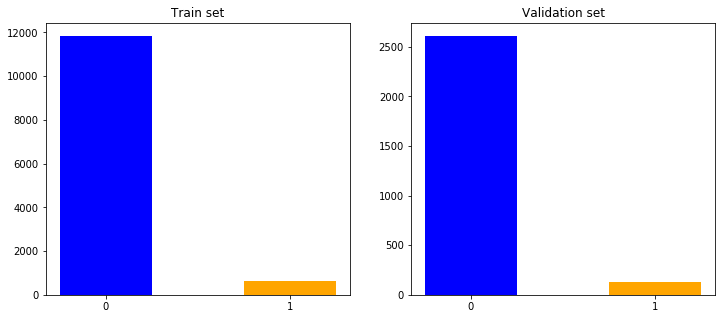

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.bar("0", len(y_train[y_train ==0]), color = ('blue'), width = 0.5)
ax1.bar("1", len(y_train[y_train ==1]), color = ('orange'), width = 0.5)

ax1.title.set_text("Train set")

ax2.bar("0", len(y_val[y_val ==0]), color = ('blue'), width = 0.5)
ax2.bar("1", len(y_val[y_val ==1]), color = ('orange'), width = 0.5)

ax2.title.set_text("Validation set")

plt.show()

To deal with this issue, we decided to oversampling the minority class only in the training set, by applying a SMOTE strategy (Synthetic Minority Oversampling Technique). 

In [37]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = "minority")
X_sm, y_sm = smote.fit_sample(X_train,y_train)
print(sum(y_sm))
print(len(y_sm))

Using TensorFlow backend.


11838
23676


We show the obtained balanced training set. Note that validation set remains umbalanced.

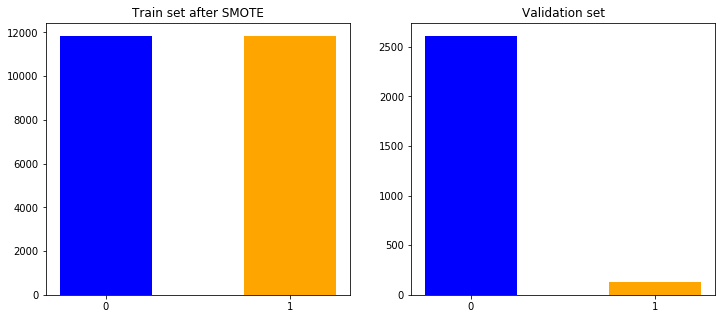

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.bar("0", len(y_sm[y_sm ==0]), color = ('blue'), width = 0.5)
ax1.bar("1", len(y_sm[y_sm ==1]), color = ('orange'), width = 0.5)

ax1.title.set_text("Train set after SMOTE")

ax2.bar("0", len(y_val[y_val ==0]), color = ('blue'), width = 0.5)
ax2.bar("1", len(y_val[y_val ==1]), color = ('orange'), width = 0.5)

ax2.title.set_text("Validation set")

plt.show()

***
# Classifier

## TNN Grid search

Sampling: we have to reduce the size of the training set after applying smote, for computational reason. In fact, performing a complete grid search for our TNN was impossible in a reasonable amount of time. Therefore we choose to reduce the size of the smoted training set obtaining a more balanced dataset of nearly the initial size (around 13 thousand of samples).

In [39]:
y_sm =pd.DataFrame(y_sm)
X_sm =pd.DataFrame(X_sm)
X_sm = X_sm.sample(n=13000, axis = 0)
y_sm = y_sm.loc[X_sm.index]

Import our TNN

In [40]:
from TurtleNN import TNN

Perform a grid search to find the best parameters among the investigated ones. Previous experimental tests, which are not included in this notebook (in order to restrict the number of investigated parameteres), showed that the best n_epochs and number of hidden units for our algorithm was 20 and 15, respectively. We therefore run the grid search keeping them fixed.

**Note**: for parameter tuning we test the result of our training on the validation set

In [41]:
n_epochs = 20
hidden_units = [15]
learning_rate = [0.03, 0.003]
reg_term = [0.001,0.01]


grid_search = [(lr,rt) for lr in learning_rate for rt in reg_term]

for combination in grid_search:
    tnn = TNN(n_epochs = n_epochs, learning_rate = combination[0], reg_lambda = combination[1], hidden_layers=hidden_units)
    
    tnn.fit(X_sm,y_sm)
    y_pred = tnn.predict(X_val)
    conf_mat = confusion_matrix(y_true = y_val, y_pred = y_pred)
    tn, fp, fn, tp = conf_mat.ravel()
    print("\tActual values")
    print("\t1\t0")
    print("1|\t",tp,"\t",fp)
    print("0|\t",fn,"\t",tn)
    print("\n1 = fraudulent, 0 = true job posting")
    print("\nAccuracy: ",np.mean(y_pred == y_val.to_numpy().flatten())) 
    print("\n---------------------------------------------")

Epoch 00:   0%|          


				     ___-------___
                                 _-~~             ~~-_
                             _-~                    /~-_
          /^\__/^\          /~  \                   /    \
         /|  O|| O|       /     \_______________/          \
        | |___||__|      /       /                \          \
        |          \    /      /                    \          \
        |   (_______) /______/                        \_________ \
        |         / /         \                      /             \
         \         \^\\         \                  /                 \     /
          \         ||           \______________/      _-_          //\__//
           \       ||------_-~~-_ ------------- \ --/~   ~\        || __/)
            ~-----||====/~      |==================|       |/~~~~~
             (_(__/  ./       /                   \_\      \.
                       (_(___/                       \_____)_)

Turtle Neural Network trained with the following parameters

Epoch 00: 100%|██████████, MSE: 0.160597
Epoch 01: 100%|██████████, MSE: 0.096898
Epoch 02: 100%|██████████, MSE: 0.076414
Epoch 03: 100%|██████████, MSE: 0.064943
Epoch 04: 100%|██████████, MSE: 0.059092
Epoch 05: 100%|██████████, MSE: 0.055744
Epoch 06: 100%|██████████, MSE: 0.053554
Epoch 07: 100%|██████████, MSE: 0.051969
Epoch 08: 100%|██████████, MSE: 0.050731
Epoch 09: 100%|██████████, MSE: 0.049713
Epoch 10: 100%|██████████, MSE: 0.048877
Epoch 11: 100%|██████████, MSE: 0.048189
Epoch 12: 100%|██████████, MSE: 0.047621
Epoch 13: 100%|██████████, MSE: 0.047139
Epoch 14: 100%|██████████, MSE: 0.046728
Epoch 15: 100%|██████████, MSE: 0.046421
Epoch 16: 100%|██████████, MSE: 0.046190
Epoch 17: 100%|██████████, MSE: 0.046005
Epoch 18: 100%|██████████, MSE: 0.045851
Epoch 19: 100%|██████████, MSE: 0.045722


NameError: name 'confusion_matrix' is not defined

We can observe how the best parameters are ???

***
# Baseline performance
## Sklearn MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha = 0.001, hidden_layer_sizes=(15), learning_rate_init=0.03)
mlp.fit(X_sm, y_sm)

Predict test set

In [ ]:
y_pred = speriamo.predict(X_test)

Visualize confusion matrix and accuracy

In [ ]:
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
tn, fp, fn, tp = conf_mat.ravel()
print("\tActual values")
print("\t1\t0")
print("1|\t",tp,"\t",fp)
print("0|\t",fn,"\t",tn)
print("\n1 = fraudulent, 0 = true job posting")
print("\nAccuracy: {0}".format(np.mean(y_pred == y_test)))

## Keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(15, input_dim=1081, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("\n---------------------------------------------")

Train the model

In [ ]:
history = model.fit(X_sm, y_sm, epochs=20)

Predict and evaluate result

In [ ]:
y_predicted = model.predict_classes(X_test)
y_predicted = y_predicted.flatten("f")

In [ ]:
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_predicted)
tn, fp, fn, tp = conf_mat.ravel()
print("\tActual values")
print("\t1\t0")
print("1|\t",tp,"\t",fp)
print("0|\t",fn,"\t",tn)
print("\n1 = fraudulent, 0 = true job posting")
print("\nAccuracy: {0}".format(np.mean(y_predicted == y_test)))
print("\n---------------------------------------------")

***
## TurtleNN

In [ ]:
tnn = TNN(20, 0.03, 0.001, [15])
    
tnn.fit(X_sm,y_sm)
y_pred = tnn.predict(X_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
tn, fp, fn, tp = conf_mat.ravel()

print("\tActual values")
print("\t1\t0")
print("1|\t",tp,"\t",fp)
print("0|\t",fn,"\t",tn)
print("\n1 = fraudulent, 0 = true job posting")
print("\nAccuracy: ",np.mean(y_pred == y_test.to_numpy().flatten())) 
print("\n---------------------------------------------")